# deal with uncertainty in recorded events 

We are unsure of how much we should take the exact date of drought events seriously
1. A news article (or desinventar report) is published not perse at the onset of a drought
2. droughts are not point events: they may last longer than single months 


For this we 'coarse-grain' the events: "move from a value for every month to 1 value for every i.e. 3 months"
Hence, we can use such data to ask: 
"Does a drought mean that there was low rainfall in any of the preceeding/surrounding months"? 






In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 

# --- load data --- 
DroughtData = pd.read_csv('datasets/Droughts_satelite_and_events_Znormed_ReducedNegatives.csv')
districts_with_droughts = pd.read_csv('datasets/districts_with_droughts_Uganda_Kenya.csv')

## metrics 

"A drought means that ANY of the months in the window, this quantity was low"
(use minimal values) 
    * SPEI / rainfall / precipitation .... 
    * NDVI / EVI  
    * soil moisture 
        * wind speed 
    
Similarly, we expect a drought to correlate with maximal values in: 
    * evapotranspiration 
    * soil temperature 
    * air temperature 
        * wind speed 
    
Not sure about wind speed (use both) 



Also, used median value for all indicators. 

In [2]:
features = list( DroughtData.columns.drop(['Country','District','date','day','month','year',
                                     'drought_reported','drought_desinventar','drought_news_article']) )


features_min_val = ['NDVI','EVI', 'rainfall',
                    'precipitation_per_hour_v1',
'precipitation_per_hour_v2',
'SoilMoisture00_10cm',
'SoilMoisture10_40cm',
'SoilMoisture40_100cm',
'SoilMoisture100_200cm',                    
'SPEI_1month',
'SPEI_2month',
'SPEI_3month',
'SPEI_4month',
'SPEI_5month',
'SPEI_6month',
'SPEI_7month',
'SPEI_8month',
'SPEI_9month',
'SPEI_10month',
'SPEI_11month',
'SPEI_12month',
'wind_speed']



features_max_val = ['evapotranspiration',
'surface_temperature_daytime',
'surface_temperature_nighttime',
'air_temperature',
'SoilTemperature00_10cm',
'SoilTemperature10_40cm',
'SoilTemperature40_100cm',
'SoilTemperature100_200cm',
'wind_speed']

In [84]:
def apply_sliding_window(data, window_size=3):
    '''
    returns set of indices for all the overlapping windows
    
    at boundary of dataframe, windows are smaller 
    '''
    windows = []
    for i in range(len(data)):
        start_index = max(min(data.index), min(data.index) + int( i - np.floor(0.5*(window_size-1))) )
        stop_index  = min(max(data.index), min(data.index) + int( i + np.ceil(0.5*(window_size-1)))  )
        window_index = list(range(start_index, stop_index+1))    
        windows.append(window_index)
    return windows


def apply_metric(data, columns_to_calc,  method='min'):
    if method == 'min':
        values = data[columns_to_calc].min(skipna=True)
    elif method == 'max':
        values = data[columns_to_calc].max(skipna=True)
    elif method == 'med':
        values = data[columns_to_calc].median(skipna=True)
        
    change_names ={}
    for name in columns_to_calc:
        change_names[name] = name + '_' + method
        
    return values.rename(index=change_names)


sliding_window_data = pd.DataFrame()
for district in DroughtData['District'].unique():
    group = DroughtData[DroughtData['District']==district]
    
#     print(district)
    
    windows = apply_sliding_window(group) 
    
    district_data = pd.DataFrame()
    for w in windows:
        #--- slice dataframe into this window ---- 
        window_data = group.loc[w]
        # --- get maximum of indicators we think should positively correlate with droughts ---- 
        metric_max = apply_metric(window_data, columns_to_calc=features_max_val, method='max')
        
        # --- get minimum of indicators we think should negatively correlate with droughts ---- 
        metric_min = apply_metric(window_data, columns_to_calc=features_min_val, method='min')
        
        # --- get median values for all indicators per window ----- 
        metric_med = apply_metric(window_data, columns_to_calc=features, method='med')
        
        # --- merge together ---- 
        metrics_window = pd.concat([metric_max,metric_min, metric_med])
        
        # --- drought reported within this window? ---- 
        #### COULD ADD THE COLUMNS INDICATING IF IT IS DESINVENTAR OR NEWS ARTICLES #### 
        metrics_window['drought_reported'] = int(window_data['drought_reported'].sum())
        
        # --- add together ----  
        district_data = pd.concat([district_data,metrics_window.to_frame().transpose()], sort=True)
    
    # --- add the information of the district back into dataframe ---- 
    district_data.reset_index(inplace=True, drop=True)
    district_data['District'] = group.reset_index()['District']
    district_data['Country'] = group.reset_index()['Country']
    district_data['Date_start_window'] = group.reset_index()['date']
    
    
    # --- merge all data (all districts) together in combined dataset ----- 
    sliding_window_data = pd.concat([sliding_window_data, district_data],sort=True)
    
#     if district == 'ADJUMANI':
#         break 
    
         


## save into .csv file 

In [86]:
sliding_window_data.to_csv('datasets/Droughts_satelite_and_events_Znormed_slinding_window_3Months.csv', index=False)

# Did correlations improve? 

/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until 

/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until 

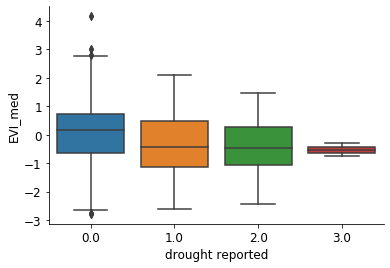

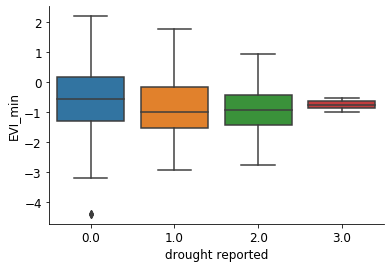

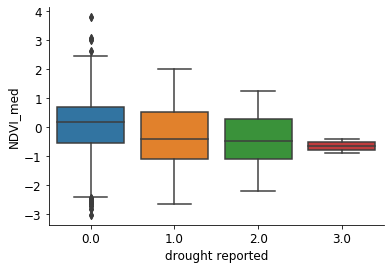

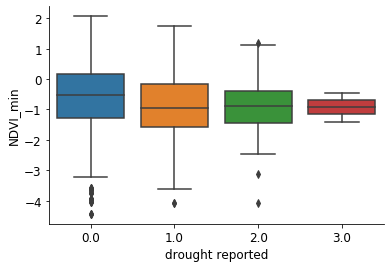

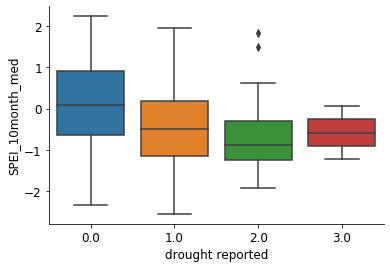

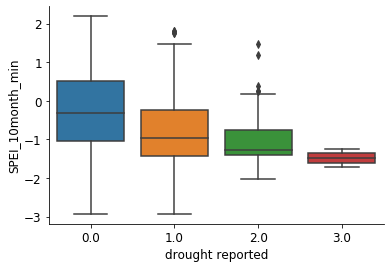

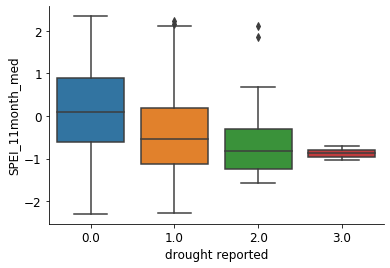

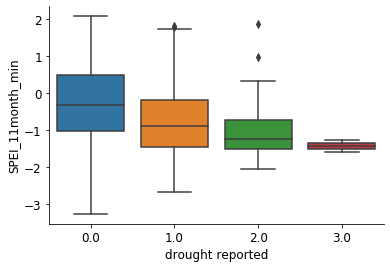

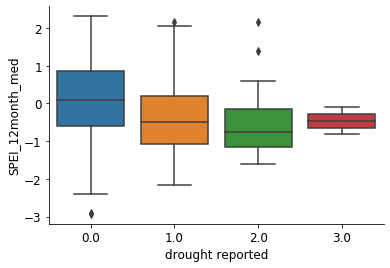

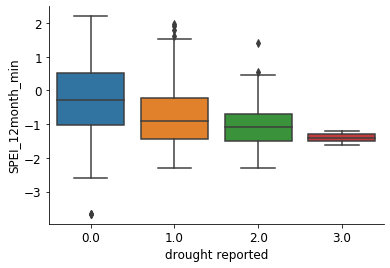

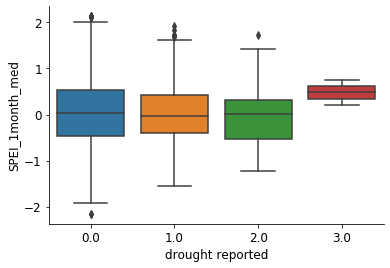

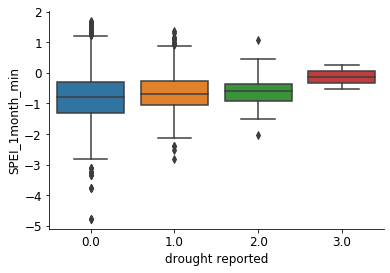

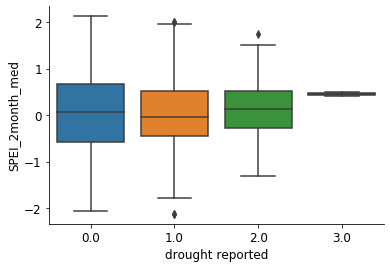

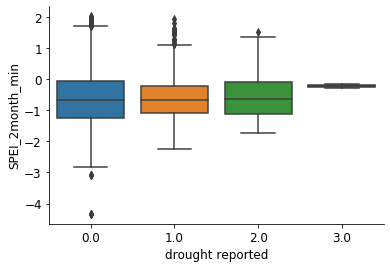

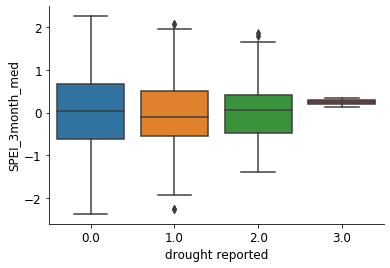

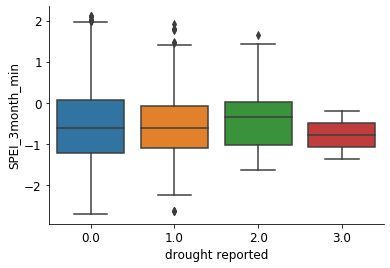

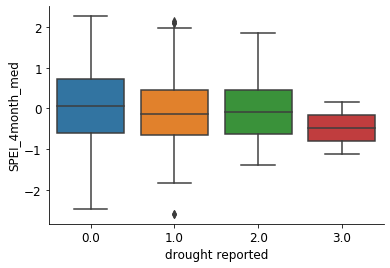

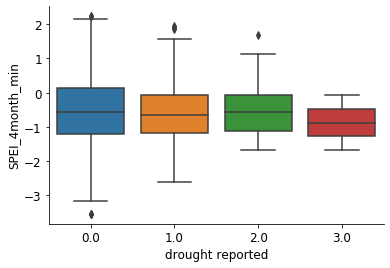

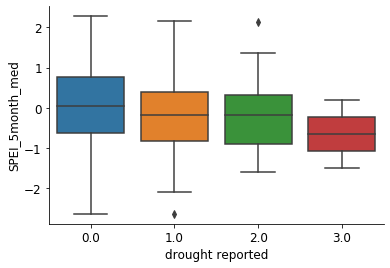

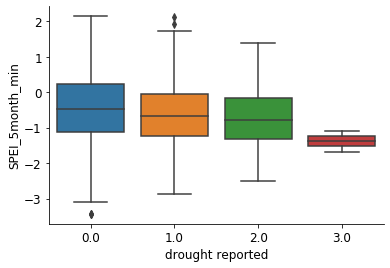

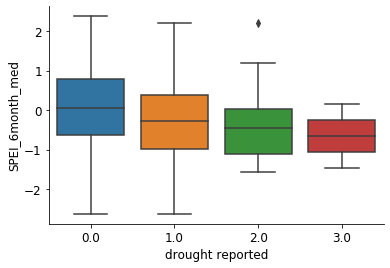

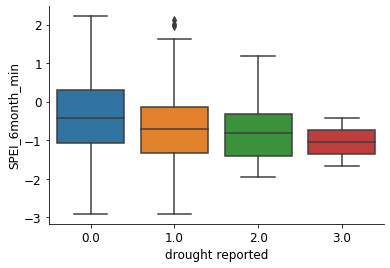

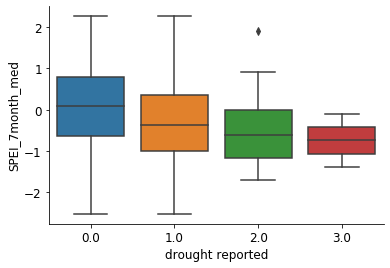

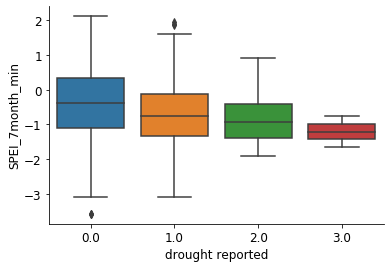

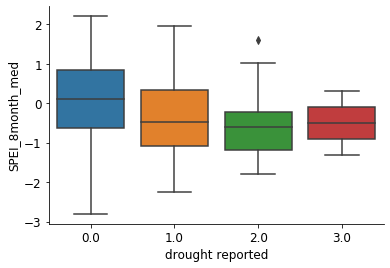

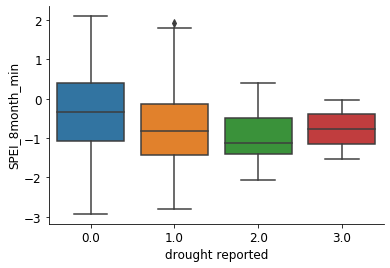

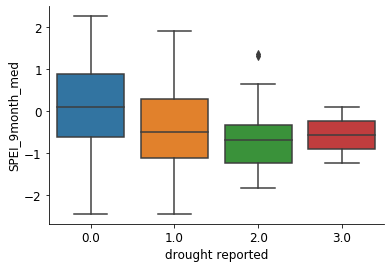

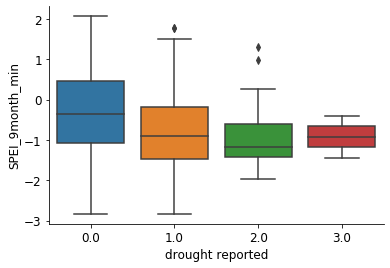

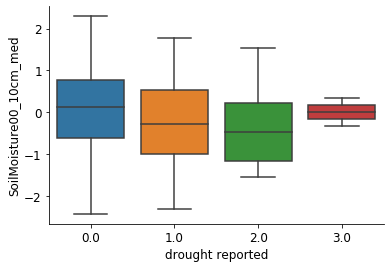

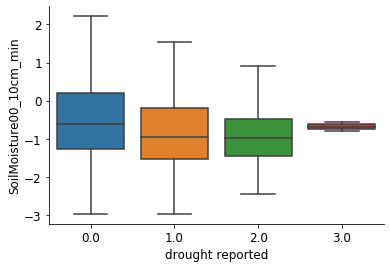

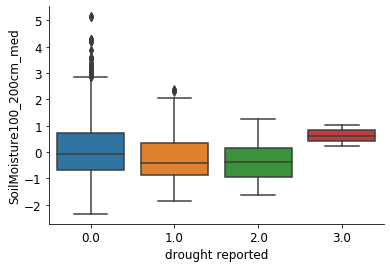

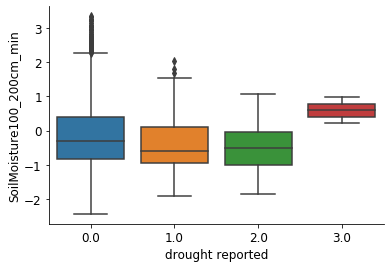

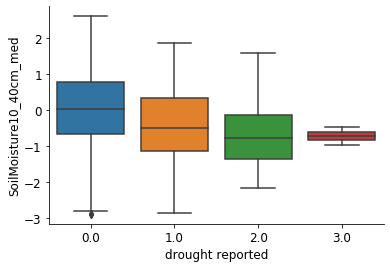

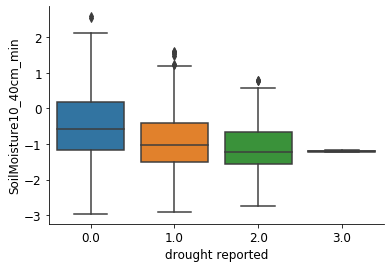

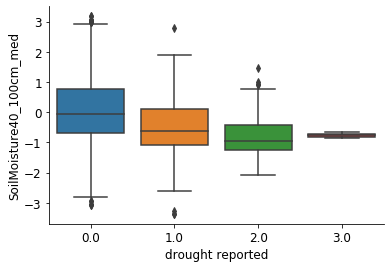

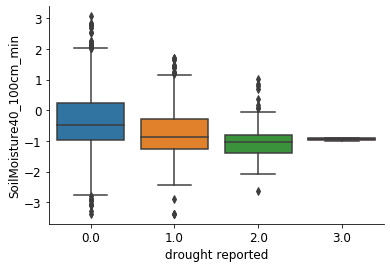

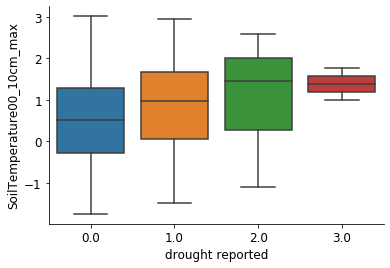

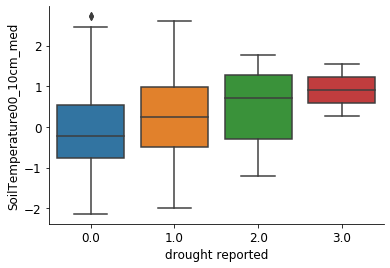

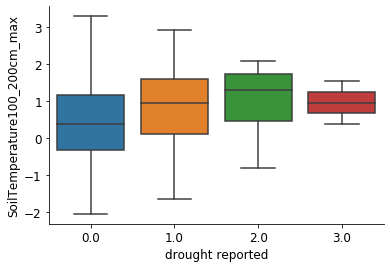

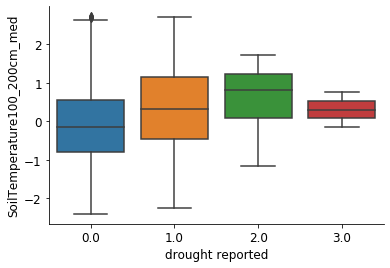

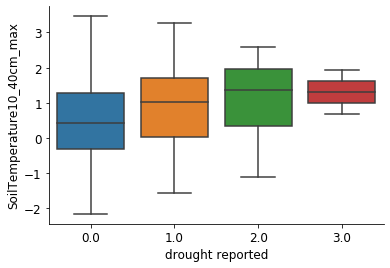

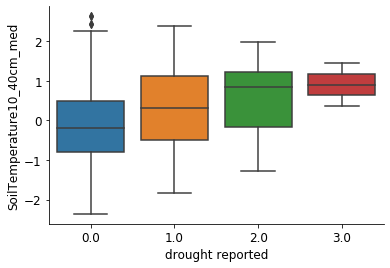

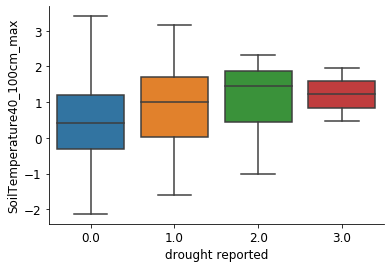

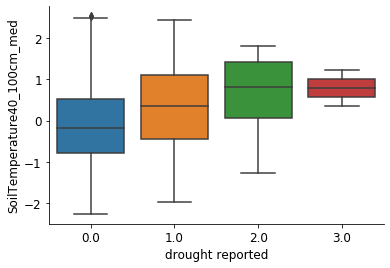

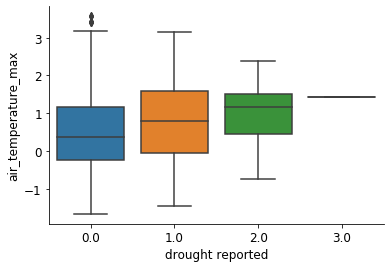

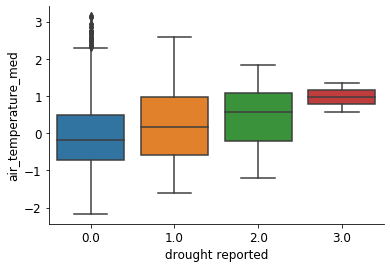

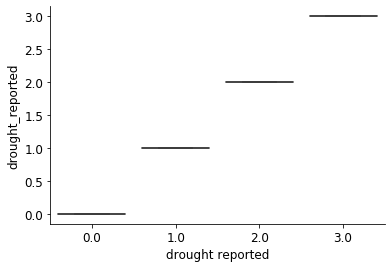

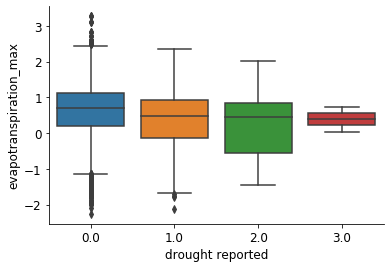

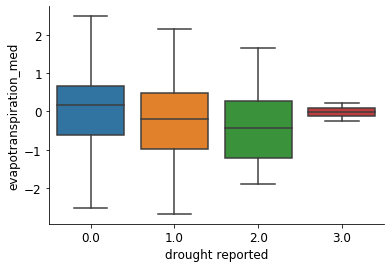

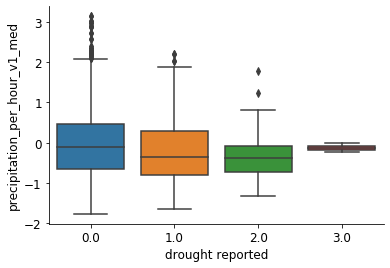

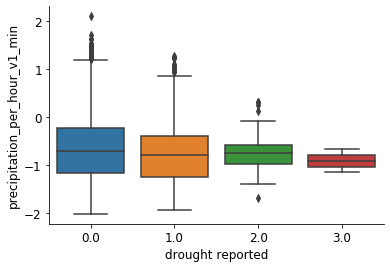

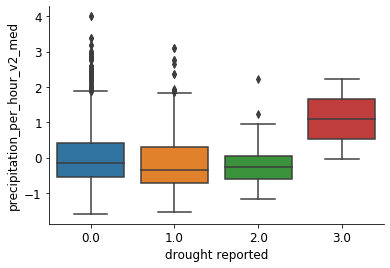

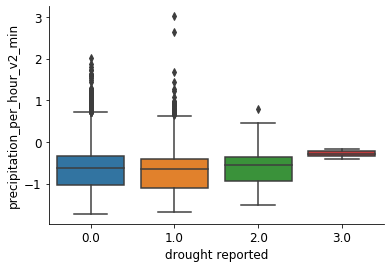

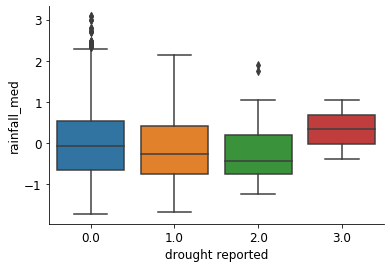

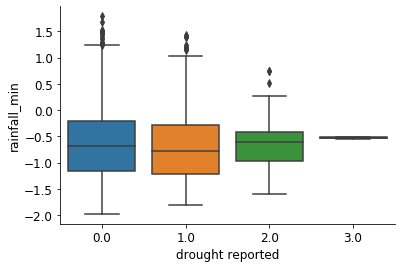

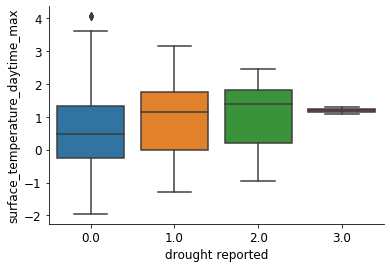

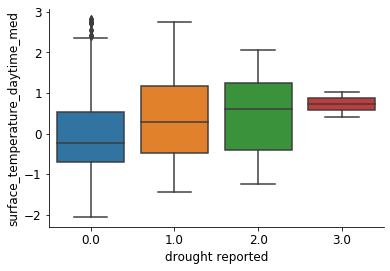

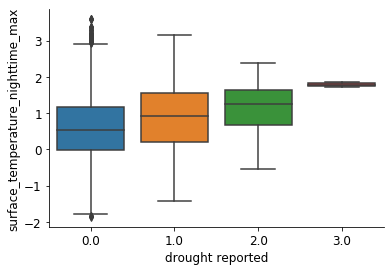

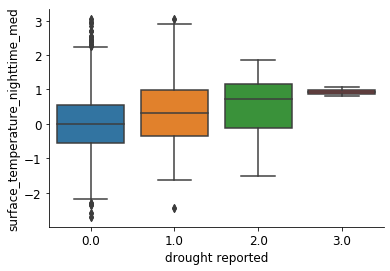

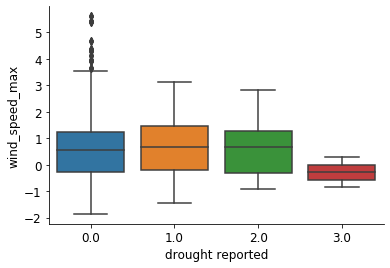

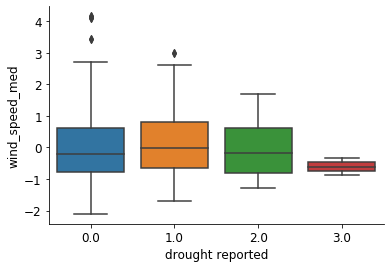

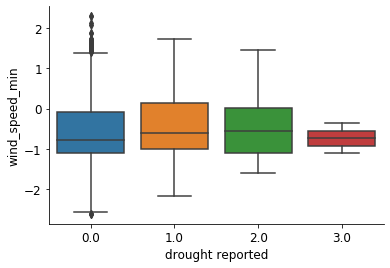

In [87]:
indicators = list(sliding_window_data.columns.drop(['Country','District','Date_start_window']))

for var in indicators:
    plt.figure()
    sns.boxplot(x='drought_reported',y=var,data=sliding_window_data);
    plt.xlabel('drought reported', fontsize=12,color='black')
    plt.ylabel(var, fontsize=12, color="black")
    plt.xticks(rotation=0,fontsize=12, color="black")
    plt.yticks(fontsize=12, color="black");
    sns.despine();